In [20]:
import sys
import json
from os import listdir
from itertools import product
import importlib
import matplotlib.pyplot as plt
import numpy as np

import input_output
importlib.reload(input_output)
import inheritance_states
importlib.reload(inheritance_states)
import transition_matrices
importlib.reload(transition_matrices)
import genotypes
importlib.reload(genotypes)
import losses
importlib.reload(losses)
import viterbi
importlib.reload(viterbi)

<module 'viterbi' from '/Users/kelley/Projects/PhasingFamilies/phase/viterbi.py'>

In [21]:
# Read in command line arguments
chrom = '10'

data_dir = '../split_gen_ihart'
param_file = '../params/ihart_multiloss_params.json'
num_loss_regions = 2
assembly = '37'
detect_deletions = False
ped_file = '../data/v34.vcf.ped'

#data_dir = '../split_gen_spark'
#ped_file = '../data/spark.ped'
#param_file = '../parameter_estimation/params/spark_multiloss_params.json'
#num_loss_regions = 1
#assembly = '38'
#detect_deletions = True

# set up filenames
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

if param_file is not None:
    with open(param_file, 'r') as f:
        params = json.load(f)
else:
    params = estimate_parameters.error_parameters(data_dir, ped_file, chrom)

In [22]:
# pull families of interest
families = input_output.pull_families(ped_file)

families pulled 1002


In [43]:
import random

#family = random.choice(families)
family = [f for f in families if f.id=='AU1047'][0]
print('family', family.id, family.individuals)

family AU1047 ['AU1047102', 'AU1047202', 'AU1047212', 'AU1047101', 'AU1047201', 'AU1047211', 'AU1047301', 'AU1047302', 'AU1047312', 'AU1047311']


In [44]:
# create genotypes
gens = genotypes.Genotypes(len(family))

genotypes (1047553, 10)


In [45]:
importlib.reload(inheritance_states)
importlib.reload(transition_matrices)
importlib.reload(losses)

# create inheritance states
if chrom == 'X':
    states = inheritance_states.InheritanceStates(family, detect_deletions, True, num_loss_regions)
else:
    states = inheritance_states.InheritanceStates(family, detect_deletions, detect_deletions, num_loss_regions)

# create transition matrix
transitions = transition_matrices.TransitionMatrix(states, params)
                
# create loss function
loss = losses.LazyLoss(states, gens, family, params, num_loss_regions)


inheritance states (128, 21)
transitions (128, 8)
AU1047102	0/0		0/1		1/1		./.
0/0	0.00-0.00	inf-inf	inf-inf	inf-inf
0/1	0.00-0.00	inf-inf	inf-inf	inf-inf
1/1	0.00-0.00	inf-inf	inf-inf	inf-inf
-/0	0.00-0.00	inf-inf	inf-inf	inf-inf
-/1	0.00-0.00	inf-inf	inf-inf	inf-inf
-/-	0.00-0.00	inf-inf	inf-inf	inf-inf
AU1047202	0/0		0/1		1/1		./.
0/0	0.00-0.00	3.90-2.94	5.64-4.57	3.41-2.48
0/1	2.47-1.88	0.00-0.01	3.11-2.16	3.34-2.18
1/1	5.55-3.94	3.66-2.20	0.00-0.01	3.32-2.66
-/0	0.00-0.00	3.90-2.94	5.64-4.57	3.41-2.48
-/1	5.55-3.94	3.66-2.20	0.00-0.01	3.32-2.66
-/-	3.58-2.04	5.60-4.25	3.90-2.94	0.00-0.00
AU1047212	0/0		0/1		1/1		./.
0/0	0.00-0.00	3.90-2.94	5.30-4.39	3.52-2.46
0/1	2.44-1.75	0.00-0.02	3.14-2.05	3.40-2.03
1/1	4.15-3.93	3.66-2.20	0.00-0.01	3.51-2.59
-/0	0.00-0.00	3.90-2.94	5.30-4.39	3.52-2.46
-/1	4.15-3.93	3.66-2.20	0.00-0.01	3.51-2.59
-/-	3.58-2.04	4.72-4.16	3.90-2.94	0.00-0.00
AU1047101	0/0		0/1		1/1		./.
0/0	0.00-0.00	inf-inf	inf-inf	inf-inf
0/1	0.00-0.00	inf-inf	inf-inf	inf-inf
1/

In [47]:
import input_output
importlib.reload(input_output)

# pull genotype data for this family
family_genotypes, family_snp_positions, mult_factor = input_output.pull_gen_data_for_individuals(data_dir, assembly, chrom, family.individuals)
print('Data pulled')


genotypes pulled (10, 559299)
Data pulled


In [50]:
print(family_genotypes[:, :5])

[[0 0 0 0 0]
 [0 2 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 2 0 0 0]
 [0 2 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]


In [51]:
# forward sweep
v_cost = viterbi.viterbi_forward_sweep(family_genotypes, family_snp_positions, mult_factor, states, transitions, loss)




Forward sweep complete 134.70230889320374 sec


In [53]:
importlib.reload(viterbi)

# backward sweep
final_states = viterbi.viterbi_backward_sweep(v_cost, states, transitions)


Num solutions (1,) 36820.760980894745 (array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
      dtype=int8),)
(1,)
Num positions in fork 5712
Backward sweep complete 67.51300477981567 sec


In [54]:
print(final_states[:, 0])
print(final_states[:, 1])

print(final_states[:, -2])
print(final_states[:, -1])

[1 1 1 1 1 1 1 1 0 1 2 3 4 5 6 7 0 6 1 7 2 0 3 0 4 1 4 1 0]
[1 1 1 1 1 1 1 1 0 1 2 3 4 5 6 7 0 6 1 7 2 0 3 0 4 1 4 1 0]
[1 1 1 1 1 1 1 1 0 1 2 3 4 5 6 7 0 6 1 7 2 0 3 0 4 1 5 7 1]
[1 1 1 1 1 1 1 1 0 1 2 3 4 5 6 7 0 6 1 7 2 0 3 0 4 1 5 7 1]


In [55]:
print(np.sum(final_states[0, :]==0))
print(np.sum(final_states[1, :]==0))
print(np.sum(final_states[2, :]==0))
print(np.sum(final_states[3, :]==0))
print(np.sum(final_states[4, :]==0))
print(np.sum(final_states[5, :]==0))

0
0
0
0
0
0


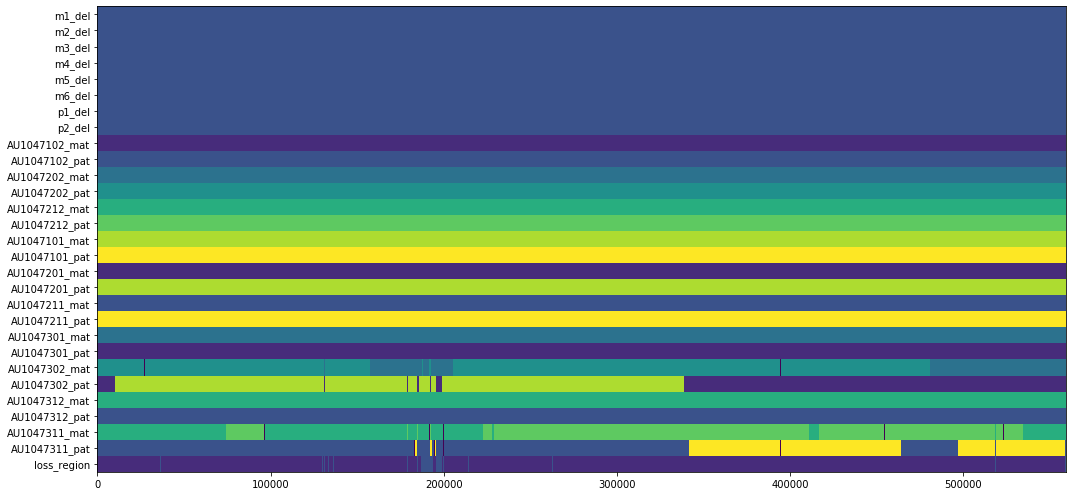

In [56]:
final_states_greyed = final_states.copy()
final_states_greyed[:, final_states[-1, :]!=0] = -1

plt.figure(figsize=(15, 7))
plt.imshow(final_states, aspect='auto', vmin=-1)
plt.yticks(np.arange(final_states.shape[0]), 
           ['m%d_del' % i for i in range(1, 2*len(family.mat_ancestors)+1)] + ['p%d_del' % i for i in range(1, 2*len(family.pat_ancestors)+1)] + \
           sum([['%s_mat' % x,'%s_pat' % x] for x in family.individuals], []) + ['loss_region'])

#plt.subplot(2, 1, 2, sharex=ax)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=0) & (family_snp_positions[:, 1]<=20500000), alpha=0.5)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=9600000) & (family_snp_positions[:, 1]<=16300000))
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 1]<=9600000) | (family_snp_positions[:, 0]>=48200000))

#plt.xticks(xticks, xlabels, rotation=90)

#plt.subplot(3, 1, 3)
#plt.plot(np.log2(family_snp_positions[:, 1]-family_snp_positions[:, 0]), marker='.', linestyle='')
#plt.plot(c[1:]-c[:-1], marker='.', linestyle='')
#plt.plot(num_non_mend, marker='.', linestyle='')
#plt.plot(np.convolve(num_non_mend, np.ones((100,)), mode='same'))
#plt.plot(np.convolve(num_missing, np.ones((100,)), mode='same'))
#plt.scatter(family_snp_positions[:, 0], final_states[-1, :], marker='.')
#plt.xticks(family_snp_positions[xticks, 0], xlabels, rotation=90)
#for i in np.where(family_snp_positions[:, 1]-family_snp_positions[:, 0] > 10000)[0]:
#    plt.plot([family_snp_positions[i, 0], family_snp_positions[i, 1]], [final_states[-1, i], final_states[-1, i]], color='grey')
#    #print(family_snp_positions[i, :])
plt.tight_layout()
plt.show()

In [ ]:
sample_id_to_sex = input_output.pull_sex(ped_file)

print([sample_id_to_sex[x] for x in family.individuals])


In [ ]:
#importlib.reload(input_output)
#
#with open('../phased_ihart/chr.%s.%s.phased.txt' % (chrom, family.id), 'w+') as phasef:
#    phasef.write('\t'.join(['family'] + \
#                           ['m%d_del' % i for i in range(1, 2*len(family.mat_ancestors)+1)] + \
#                           ['p%d_del' % i for i in range(1, 2*len(family.pat_ancestors)+1)] + \
#                           sum([['%s_mat' % x, '%s_pat' % x] for x in family.individuals], []) + \
#                           ['loss_region', 'start_pos', 'end_pos']) + '\n')
#    input_output.write_to_file(sys.stdout, phasef, family, final_states, family_snp_positions)




In [ ]:
import ancestral_variants
importlib.reload(ancestral_variants)

ancs = -np.ones((len(family), family_genotypes.shape[1]))
change_indices = [-1] + np.where(np.any(final_states[:, 1:]!=final_states[:, :-1], axis=0))[0].tolist() + [family_snp_positions.shape[0]-1]
for j in range(1, len(change_indices)):
    s_start, s_end = change_indices[j-1]+1, change_indices[j]
    assert np.all(final_states[:, s_start] == final_states[:, s_end])
    if np.all(final_states[:, s_start]>=0):
        state = states.get_original_state(final_states[:, s_start])
        variants = ancestral_variants.AncestralVariants(states, gens, loss, family, state)
        for i in range(s_start, s_end+1):
            ancs[:, i] = variants(tuple(family_genotypes[:, i]))
    
    

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(ancs, aspect='auto')
plt.show()

print(np.unique(ancs, return_counts=True))

In [ ]:
is_hts = final_states[-1, :]==1
has_m1_deletion = final_states[0, :]==0
has_m2_deletion = final_states[1, :]==0
has_p1_deletion = final_states[2, :]==0
has_p2_deletion = final_states[3, :]==0

preferred_phase_options = [[0, -1], [1, -1], [2, -1], [3, -1], [0, -1], [2, -1]] + [[0, 1, -1], [2, 3, -1]]*(m-3)

has_upd = np.zeros((2*m, final_states.shape[1]), dtype=bool)
for i in range(m):
    has_upd[2*i, :] = ~np.isin(final_states[4+2*i, :], preferred_phase_options[2*i])
    has_upd[2*i + 1, :] = ~np.isin(final_states[5+2*i, :], preferred_phase_options[2*i + 1])

print('hard to sequence', np.sum(mult_factor * is_hts)/np.sum(mult_factor))     

print('m1 deletion', np.sum(mult_factor * (has_m1_deletion & ~is_hts)))
print('m2 deletion', np.sum(mult_factor * (has_m2_deletion & ~is_hts)))
print('p1 deletion', np.sum(mult_factor * (has_p1_deletion & ~is_hts)))
print('p2 deletion', np.sum(mult_factor * (has_p2_deletion & ~is_hts)))

# maternal UPD
print('maternal UPD', np.sum(mult_factor * ((has_upd[0, :] | has_upd[1, :]) & ~is_hts)))
print('paternal UPD', np.sum(mult_factor * ((has_upd[2, :] | has_upd[3, :]) & ~is_hts)))

for i in range(m-2):
    print('child%d mat upd' % (i+1), np.sum(mult_factor * (has_upd[4+2*i, :] & ~is_hts)))
    print('child%d pat upd' % (i+1), np.sum(mult_factor * (has_upd[5+2*i, :] & ~is_hts)))


In [ ]:
#event = has_p1_deletion & ~is_hts
event = has_upd[6, :]
del_start = np.where(~event[:-1] & event[1:])[0]+1
del_end = np.where(event[:-1] & ~event[1:])[0]+1

print(len(del_start), len(del_end))
print(del_start, del_end)

# remove events in hard to sequence regions
event_is_hts = np.ones((del_start.shape[0],), dtype=bool)
for i, (s, e) in enumerate(zip(del_start, del_end)):
    event_is_hts[i] = np.any(is_hts[s:e])
print('hard to seq', event_is_hts)
    
#del_start = np.array(del_start)[~event_is_hts]
#del_end = np.array(del_end)[~event_is_hts]
#print(len(del_start), len(del_end))

print(del_start, del_end)

In [ ]:
dstart, dend = random.choice(list(zip(del_start, del_end)))
start, end = max(0, dstart-100), min(dend+100, family_genotypes.shape[1])

print(final_states[:, start])
#print(dstart, dend)
#print(family_snp_positions[dstart, :], family_snp_positions[dend, :])
#start, end = 168156000, 168172000
#start, end = 71706745, 71715561
#start, end = 225044, 225185

#start, end = 3711060, 3711393
#start, end = np.where(family_snp_positions[:, 0]>=start)[0][0], np.where(family_snp_positions[:, 0]<=end)[0][-1]
#start, end = max(0, start-100), min(end+100, family_genotypes.shape[1])

state_indices_of_interest = []

plt.figure(figsize=(15, 10))
ax = plt.subplot(4, 1, 1)
plt.plot(mult_factor[start:end])

plt.subplot(4, 1, 2, sharex=ax)
plt.imshow(family_genotypes[:, start:end], aspect='auto', vmin=-3, vmax=2)
plt.yticks(np.arange(m), ['mom', 'dad'] + ['child %d' % i for i in range(1, m-1)])

plt.subplot(4, 1, 3, sharex=ax)
plt.imshow(final_states[[0, 1, 2, 3] + \
                               [4, 5] + np.arange(8, 4+(2*m), 2).tolist() + \
                               [6, 7] + np.arange(9, 4+(2*m), 2).tolist() + [-1], start:end],
           aspect='auto', vmin=-1, vmax=3)
plt.yticks(np.arange(final_states.shape[0]), 
           ['m1 del', 'm2 del', 'p1 del', 'p2 del', 'm1', 'm2'] + ['child_%d mat' % i for i in range(1, m-1)] + ['p1', 'p2'] + ['child_%d pat' % i for i in range(1, m-1)] + ['is_hts'])

#plt.subplot(4, 1, 4, sharex=ax)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.clip(final_states[:, j], 0, None)))] for j in range(start, end)], alpha=0.5)

#plt.subplot(5, 1, 5, sharex=ax)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.clip(final_states[:, j], 0, None)))] for j in range(start, end)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.hstack((np.clip(final_states[:2*m, j], 0, None), [0,]*(2*(m-2)), [np.clip(final_states[-1, j], 0, None)]))))] for j in range(start, end)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.hstack(([1,]*4, np.clip(final_states[4:, j], 0, None)))))] for j in range(start, end)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0))] for j in range(start, end)], alpha=0.5)
#plt.plot(np.cumsum([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0))] for j in range(start, end)]), alpha=0.5)
#plt.plot(np.cumsum([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0))] for j in range(start, end)]), alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0))] for j in range(start, end+1)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0))] for j in range(start, end+1)], alpha=0.5)



plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 3))
plt.imshow(family_genotypes[:, start:end], aspect='auto', vmin=-3, vmax=2)
plt.show()

In [ ]:
markers = []
labels = []
with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] == chrom:
            markers.append(int(pieces[1]))
            labels.append(chrom + pieces[3])

plt.figure(figsize=(15, 3))
x = sum([[s-1, s, e, e+1] for s, e in zip(family_snp_positions[del_start, 0], family_snp_positions[del_end, 1])], [])
y = sum([[0, 1, 1, 0] for s, e in zip(del_start, del_end)], [])
plt.plot(x, y)
plt.xticks([x for x in markers if x>= plt.xlim()[0] and x<=plt.xlim()[1]], 
           [l for x, l in zip(markers, labels) if x>= plt.xlim()[0] and x<=plt.xlim()[1]], rotation=90)
plt.show()

In [ ]:
print(inds)

In [ ]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(m, 1, 1)

for i in range(4):
    #plt.scatter(family_snp_positions[final_states_greyed[i, :] == -1, 0], np.repeat(3-i, np.sum(final_states_greyed[i, :] == -1)), color='blue', alpha=0.5)
    plt.scatter(family_snp_positions[final_states_greyed[i, :] == 0, 0], np.repeat(3-i, np.sum(final_states_greyed[i, :] == 0)), color='red', alpha=0.5)
plt.title('Deletions')
plt.yticks(range(3, -1, -1), ['m1', 'm2', 'p1', 'p2'])

for i in range(0, m-2):
    plt.subplot(m, 1, i+2, sharex=ax)
    indices = (final_states_greyed[4+(2*i), :] == 0) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(0, np.sum(indices)), color='blue', alpha=0.5)
    indices = (final_states_greyed[4+(2*i), :] == 1) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(0, np.sum(indices)), color='red', alpha=0.5)

    indices = (final_states_greyed[5+(2*i), :] == 0) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(1, np.sum(indices)), color='blue', alpha=0.5)
    indices = (final_states_greyed[5+(2*i), :] == 1) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(1, np.sum(indices)), color='red', alpha=0.5)

    plt.title('Child%d' % (i+1))
    plt.yticks(range(0, 2), ['mat', 'pat'])

plt.subplot(m, 1, m, sharex=ax)
plt.scatter(family_snp_positions[final_states_greyed[-1, :] == -1, 0], np.repeat(0, np.sum(final_states_greyed[-1, :] == -1)), color='blue', alpha=0.5)
plt.scatter(family_snp_positions[final_states_greyed[-1, :] == 1, 0], np.repeat(0, np.sum(final_states_greyed[-1, :] == 1)), color='red', alpha=0.5)
plt.title('Hard to sequence')

plt.tight_layout()
plt.show()



In [ ]:
print(family_snp_positions[start, :], family_snp_positions[end, :])

In [ ]:
import numpy as np
def estimate_parental_variants(final_states, family_genotypes):
    m, n = family_genotypes.shape
    parental_variants, cost, blame = -np.ones((4, n), dtype=np.int8), -np.ones((n,), dtype=int), -np.ones((m, n), dtype=float)
    has_missing = 0
    for i in range(n):
        state, gen = final_states[:, i], tuple(family_genotypes[:, i])
        
        missing_indices = [i for i, x in enumerate(state) if x==-1]
        
        if len(missing_indices) == 0:
            pv, v, b = loss.get_parental_variants(tuple(state), gen)
            parental_variants[:, i] = pv
            cost[i] = v
            blame[:, i] = b
        else:
            has_missing += 1
            all_possible_states = np.tile(state, (pow(2, len(missing_indices)), 1))
            all_possible_states[:, missing_indices] = list(product(*[[0, 1]]*len(missing_indices)))

            min_v = None
            all_pvs, all_bs = [], []
            for s in all_possible_states:
                pv, v, b = loss.get_parental_variants(tuple(s), gen)
                if min_v is None or v < min_v:
                    min_v = v
                    all_pvs, all_bs = [pv], [b]
                elif v == min_v:
                    all_pvs.append(pv)
                    all_bs.append(b)

            all_pvs, all_bs = np.asarray(all_pvs), np.asarray(all_bs)
            parental_variants[np.all(all_pvs==-2, axis=0), i] = -2
            parental_variants[np.all(all_pvs==0, axis=0), i] = 0
            parental_variants[np.all(all_pvs==1, axis=0), i] = 1
            cost[i] = min_v
            
            all_bs = np.sum(all_bs, axis=0)
            if min_v == 0:
                blame[:, i] = 0
            else:
                blame[:, i] = min_v*all_bs/np.sum(all_bs)
            
        if i%10000==0:
            print(i, has_missing)
    return parental_variants, cost, blame

parental_variants, cost, blame = estimate_parental_variants(states, family_genotypes)       

In [ ]:
import time
import numpy as np
from itertools import product

def mask_states(family_genotypes, mult_factor, final_states, inheritance_states, loss, error_rate=0.001, smooth=5000):

	masked_final_states = np.copy(final_states)
	# Now, do masking
	prev_time = time.time()
	m, n = family_genotypes.shape
	p, state_len = inheritance_states.p, inheritance_states.state_len

	fit = -np.ones((n,), dtype=int)
	prev_state = None
	prev_state_indices = None
	for j in range(n): 
		pos_gen = tuple(family_genotypes[:, j])
		current_state = tuple(final_states[:, j])

		if current_state != prev_state:
			prev_state = current_state
			num_unknowns = len([x for x in current_state if x == -1])
			if num_unknowns>0:
				prev_state_indices = []
				for poss_itr in [iter(x) for x in product(*([[0, 1]]*num_unknowns))]:
					poss_state = tuple([x if x != -1 else next(poss_itr) for x in current_state])
					prev_state_indices.append(inheritance_states.index(poss_state))
			else:
				prev_state_indices = [inheritance_states.index(tuple(final_states[:, j]))]

		fit[j] = mult_factor[j]*(np.min(loss(pos_gen)[prev_state_indices])==1)
        
	print(np.unique(fit, return_counts=True))


	c = np.convolve(fit/m, np.ones(smooth,), mode='same')
	masked = (c>(error_rate*smooth)).astype(np.int8)
	print('Percent masked', 100*np.sum(masked)/n)

	# if a parental chromosome isn't inherited, then we don't know if it has a deletion
	maternal_indices = range(4, state_len, 2)
	paternal_indices = range(5, state_len, 2)

	m1_ninh = np.all(final_states[maternal_indices, :]!=0, axis=0)
	m2_ninh = np.all(final_states[maternal_indices, :]!=1, axis=0)
	p1_ninh = np.all(final_states[paternal_indices, :]!=0, axis=0)
	p2_ninh = np.all(final_states[paternal_indices, :]!=1, axis=0)

	masked_final_states[0, m1_ninh] = -1
	masked_final_states[1, m2_ninh] = -1
	masked_final_states[2, p1_ninh] = -1
	masked_final_states[3, p2_ninh] = -1
	masked_final_states = np.append(masked_final_states, masked[np.newaxis, :], axis=0)
	print('Percent never inherited', 100*np.sum(m1_ninh)/n, 100*np.sum(m2_ninh)/n, 100*np.sum(p1_ninh)/n, 100*np.sum(p2_ninh)/n)

	print('Masking complete', time.time()-prev_time, 'sec') 
	return masked_final_states, c

In [ ]:
# mask messy areas
masked_final_states, f = mask_states(family_genotypes, mult_factor, final_states, inheritance_states, loss, error_rate=0.01)
#masked_final_states[:, masked_final_states[-1, :]==1] = -1

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(f/1000)
plt.plot(overall)
plt.show()

In [ ]:
smooth=5000
c = np.convolve(np.sum(parental_variants==-2, axis=0), np.ones(smooth,), mode='same')/(smooth*m)
d = np.convolve(np.sum(parental_variants==-1, axis=0), np.ones(smooth,), mode='same')/(smooth*m)

plt.figure(figsize=(15, 5))
plt.plot(a, label='deletion')
plt.plot(b, label='unknown')
plt.plot(c, label='deletion')
plt.plot(d, label='unknown')
#plt.plot(overall)
#plt.ylim([0, 0.1])
plt.axhline(0.01)
plt.legend()
plt.show()

In [ ]:
print(np.sum(parental_variants==-1)/(4*parental_variants.shape[1]))

In [ ]:
print(np.sum(blame==0)/(blame.shape[0]*blame.shape[1]))
print(np.sum(parental_variants==0)/(parental_variants.shape[0]*parental_variants.shape[1]))


In [ ]:
pos_lens = family_snp_positions[:, 1]-family_snp_positions[:, 0]
print(pos_lens.shape)
print(np.sum(parental_variants!=0))
print(np.sum(mult_factor*np.sum(parental_variants!=0, axis=0)))
print(np.sum(mult_factor[np.any(parental_variants!=0, axis=0)]))

In [ ]:
import scipy.sparse as sparse

chrom_length = chrom_lengths[chrom]
nonzeros = np.sum(mult_factor*np.sum(parental_variants!=0, axis=0))
data = np.zeros((nonzeros,), dtype=np.int8)
row_ind = np.zeros((nonzeros,), dtype=int)
col_ind = np.zeros((nonzeros,), dtype=int)

data_index = 0
for i, j in zip(*np.nonzero(parental_variants)):
    pos_start, pos_end = family_snp_positions[j, :]
    pos_length = pos_end - pos_start
    
    data[data_index:(data_index+pos_length)] = parental_variants[i, j]
    row_ind[data_index:(data_index+pos_length)] = i
    col_ind[data_index:(data_index+pos_length)] = range(pos_start, pos_end)
    data_index += pos_length

parental_variants_csc = sparse.csc_matrix((data, (row_ind, col_ind)), shape=(4, chrom_length))

In [ ]:
print(np.nonzero(parental_variants)[0].shape)
print(data[:5])
print(parental_variants_csc.nnz)

In [ ]:
import random
j = random.choice(np.where(mult_factor*np.any(parental_variants!=0, axis=0)>1)[0])
print(j, family_snp_positions[j, :])
print(parental_variants[:, j])
print(parental_variants_csc[:, family_snp_positions[j, 0]:family_snp_positions[j, 1]])

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow((parental_variants==-1)[:1000], aspect='auto')
plt.show()

In [ ]:
smooth=5000
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

ax1 = plt.subplot(2, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
plt.plot(overall, label='overall', color='black')
plt.axhline(0.01, color='black')
plt.legend()
plt.ylim([0, 0.1])

all_convolve = np.vstack((mo, d, c1, c2, c3))

plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(np.vstack((masked_final_states[-1, :], np.sum(all_convolve>0.01, axis=0)>1)), aspect='auto')

plt.show()

In [ ]:

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(3, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.subplot(3, 1, 3, sharex=ax1)
plt.imshow(masked_final_states, aspect='auto')

plt.show()

In [ ]:
smooth=5000
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(3, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.subplot(3, 1, 3, sharex=ax1)
plt.imshow(masked_final_states, aspect='auto')

plt.show()

In [ ]:
m = 5
smooth = 5000

In [ ]:
# family-wise unphased mendelian
unique_gens, indices = np.unique(family_genotypes, axis=1, return_inverse=True)

parents_to_children_with_del = {
    (-1, -1): [-1],
    (-1, 0): [-1, 0],
    (-1, 1): [0, 2],
    (-1, 2): [-1, 2],
    (0, 0): [-1, 0],
    (0, 1): [0, 1, 2],
    (0, 2): [-1, 0, 1, 2],
    (1, 1): [0, 1, 2],
    (1, 2): [0, 1, 2],
    (2, 2): [-1, 2]
    
}

parents_to_children_without_del = {
    (0, 0): [0],
    (0, 1): [0, 1],
    (0, 2): [1],
    (1, 1): [0, 1, 2],
    (1, 2): [1, 2],
    (2, 2): [2]
    
}
parental_genotypes = list(product(*[[0, 1, 2]]*2))

# without del
trio_perfect_match_gens_nodel = set()
trios_could_be_mendelian = np.zeros((family_genotypes.shape[1],), dtype=int)
for pg in parental_genotypes:
    trio_perfect_match_gens_nodel.update([pg + cg for cg in product(*[parents_to_children_without_del[(min(pg), max(pg))]]*(m-2))])

for i, gen in enumerate(unique_gens.T):
    missing_indices = [i for i, x in enumerate(gen) if x==-1]
    all_possible_gens = np.tile(gen, (pow(4, len(missing_indices)), 1))
    all_possible_gens[:, missing_indices] = list(product(*[[-1, 0, 1, 2]]*len(missing_indices)))
    #print(all_possible_gens)
    
    if np.any([tuple(g) in trio_perfect_match_gens_nodel for g in all_possible_gens]):
        trios_could_be_mendelian[indices==i] = 1



In [ ]:
print(len(trio_perfect_match_gens_del), len(trio_perfect_match_gens_nodel))

In [ ]:
smooth = 500*4
smoothed_cost = np.convolve(cost>0, np.ones(smooth,), mode='same')/smooth
smoothed_md_nodel = np.convolve(1-trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth
smoothed_final = np.convolve((cost>0) - 1 + trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 1, 1)
plt.plot(smoothed_md_nodel, label='unphased mendelian no del', alpha=0.5)
plt.plot(smoothed_cost, label='phased family mendelian', alpha=0.5)
plt.plot(smoothed_cost-smoothed_md_nodel)
plt.plot(smoothed_final)

#plt.plot(mo, label='mom')
#plt.plot(d, label='dad')
#plt.plot(c1, label='child1')
#plt.plot(c2, label='child2')
#plt.plot(c3, label='child3')
plt.axhline(0.01)
plt.legend()

to_plot = []
for smooth in [1, 50, 100, 500, 1000, 5000]:
    smooth = smooth*4
    smoothed_cost = np.convolve(cost>0, np.ones(smooth,), mode='same')/smooth
    smoothed_md_nodel = np.convolve(1-trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth
    to_plot.append(smoothed_cost-smoothed_md_nodel>0.01)


plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(np.vstack((final_states, to_plot[0], to_plot[1], to_plot[2], to_plot[3], to_plot[4], to_plot[5])), aspect='auto')

plt.show()

In [ ]:
print(np.sum(1-trios_could_be_mendelian)/2/trios_could_be_mendelian.shape)
print(np.sum(cost>0)/2/cost.shape)
print((np.sum(parental_variants[:, cost==0]==-1) + m*np.sum(cost!=0))/2/(m*cost.shape[0]))

In [ ]:
print(np.sum(smoothed_md_del > 0.01)/smoothed_md_del.shape)

plt.figure(figsize=(15, 5))
plt.hist(smoothed_md_del, bins=70)
plt.xlim([0, 0.1])
plt.show()

In [ ]:

smooth=5000
#mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
#d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
#c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
#c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
#c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
#overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth



plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.show()

In [ ]:
print(np.sum(blame[0, :]==1), np.sum(blame[1, :]==1))
print(np.sum(blame[2, :]==1), np.sum(blame[3, :]==1), np.sum(blame[4, :]==1))

In [ ]:
print('hello')

In [ ]:
smooth=500
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth


plt.figure(figsize=(15, 5))

plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()
print(np.sum(np.any(final_states[:, 1:] != final_states[:, :-1], axis=0)))

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(masked_final_states, aspect='auto')
plt.show()
print(np.sum(np.any(masked_final_states[4:, 1:] != masked_final_states[4:, :-1], axis=0)))

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(family_genotypes[:50000, :], aspect='auto')
plt.show()


In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()


In [ ]:
import numpy as np
print(np.sum((family_genotypes[2, :]==1) & (family_genotypes[[0, 1, 3], :]==0)))
print(np.sum((family_genotypes[3, :]==1) & (family_genotypes[[0, 1, 2], :]==0)))

In [ ]:
print(wgs_data.chrom_length)

In [ ]:
93326/family_genotypes.shape[1]

In [ ]:
print(np.sum((family_genotypes[2, :]==1) & np.all(family_genotypes[[0, 1, 3], :]==0, axis=0))/family_genotypes.shape[1])
print(np.sum((family_genotypes[3, :]==1) & np.all(family_genotypes[[0, 1, 2], :]==0, axis=0))/family_genotypes.shape[1])

In [ ]:
print(np.sum(np.all(family_genotypes==0, axis=0))/family_genotypes.shape[1])